### 1. Imports
We start with importing required libraries

In [16]:
import networkx as nx
from shapely.geometry import Point,LineString,Polygon

import datetime
import simpy

from opentnsim import core as core_module
from opentnsim import graph as graph_module
from opentnsim import lock as lock_module
from opentnsim import output as output_module
from opentnsim import vessel as vessel_module
from opentnsim import vessel_traffic_service as vessel_traffic_service_module

import pandas as pd

import matplotlib.pyplot as plt

#### Initialise environment
For later convenience we already initialise a simpy environment, with some additional properties related to the simulation start and stop time.

In [17]:
t_start = datetime.datetime(2024, 1, 1, 0, 0, 0)

env = simpy.Environment(initial_time=t_start.timestamp())

env.epoch = t_start
env.simulation_start = t_start

## Simplified graph with sequence of locks
In this notebook, we set up a basic simulation where a vessel moves over a 1D network path that contains sequence of locks. 

We take the following steps:

1. [Imports](#1.-Imports)
    * [Initialise environment](#Initialise-environment)
2. [Create vessel](#2.-Create-vessel)
3. [Create graph](#3.-Create-graph)
    * [Add hydrodynamic data](#3.1.-Add-hydrodynamic-data)
    * [Add lock](#3.2.-Add-lock)
4. [Run simulation](#4.-Run-simulation)
5. [Inspect output](#5.-Inspect-output)

### 2. Create vessel
We start with creating a vessel class. We call this class a *Vessel*, and add a number of OpenTNSim mix-ins to this class. Each mix-in requires certain input parameters. We wrap the creation of the vessel class in a function, to facilitate the generation of multiple vessels. 

The following mix-ins are sufficient to create a vessel for our problem: 
* _Identifiable_ - allows to give the vessel a name and a random ID, 
* _SimpyObject_ -
* _HasLock_ - the lock chamber where vessels stay during the leveling process
* _HasLineUpArea_ - a place just in front of the lock to guide vessels entering the lock chamber
* _HasWaitingArea_ - a place where vessels can wait before entering the lock
* _VesselProperties_ - allows the specification of vessel properties, such as L, B and T
* _ExtraMetadata_ -
* _HasOutput_ -

In [18]:
#We create a type element that schematisizes a vessel
def create_vessel(env, 
                  name, 
                  origin, 
                  destination, 
                  vessel_type, 
                  L, 
                  B, 
                  T,
                  arrival_time):
    Vessel = type('Vessel',(lock_module.HasLockComplex,
                            vessel_module.IsVessel,
                           ),{})    

    vessel = Vessel(
        **{ "env": env,
            "name": name,
            "origin": origin,
            "destination": destination,
            "type": vessel_type,
            "L": L,
            "B": B,
            "T": T,
            "arrival_time": arrival_time
        }
    )

    env.process(vessel.move())
    
    return vessel

### 3. Create graph
Next we create a 1D network (a graph) along which the vessel can move. A graph is made of nodes (blue dots in the plot below) and edges (red arrows between the nodes in the plot below). We use the graph_module of OpenTNSim to do this.

In [25]:
# specifiy nodes and edges
node_A = graph_module.Node(name='A',geometry=Point(0,5000))
node_B = graph_module.Node(name='B',geometry=Point(5000,5000))
node_C = graph_module.Node(name='C',geometry=Point(15000,5000))
node_D = graph_module.Node(name='D',geometry=Point(20000,5000))

node_E = graph_module.Node(name='E',geometry=Point(5000,4600))
node_F = graph_module.Node(name='F',geometry=Point(15000,4600))

node_G = graph_module.Node(name='G',geometry=Point(0,0))
node_H = graph_module.Node(name='H',geometry=Point(5000,0))
node_I = graph_module.Node(name='I',geometry=Point(12600,0))
node_J = graph_module.Node(name='J',geometry=Point(13000,0))
node_K = graph_module.Node(name='K',geometry=Point(15000,0))
node_L = graph_module.Node(name='L',geometry=Point(20000,0))
edges = [(node_A,node_B),(node_B,node_C),(node_C,node_D),
         (node_B,node_E),(node_E,node_H),
         (node_C,node_F),(node_F,node_K),
         (node_G,node_H),(node_H,node_I),(node_I,node_J),(node_J,node_K),(node_K,node_L),
        ]

# create a graph object
FG = graph_module.DiGraph(edges=edges,crs='EPSG:28992').graph
env.FG = nx.MultiDiGraph(FG)

# add a VTS to the environment to know where vessels are going
env.vessel_traffic_service = vessel_traffic_service_module.VesselTrafficService(env=env)

In [26]:
# collect node positions and labels
nodes = []
coordinates = []
labels = {}

for node in env.FG.nodes:
    nodes.append(node)
    coordinates.append([nx.get_node_attributes(env.FG, 'geometry')[node].x, nx.get_node_attributes(env.FG, 'geometry')[node].y])
    labels[node] = node
    
positions = dict(zip(nodes, coordinates))

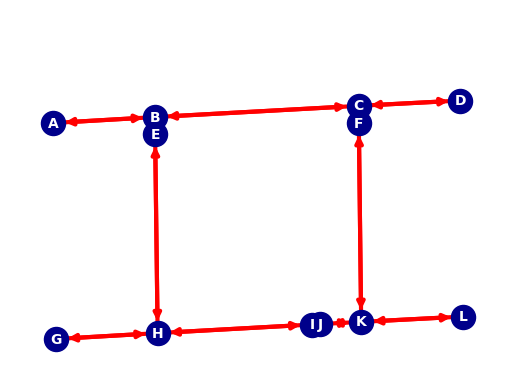

In [27]:
# draw edges, nodes and labels
nx.draw_networkx_edges(env.FG, pos=positions, width=3, edge_color="red", alpha=1, arrowsize=10)
nx.draw_networkx_nodes(env.FG, pos=positions, node_color="darkblue", node_size=300)
nx.draw_networkx_labels(env.FG, pos=positions, labels=labels, font_size=10, font_weight="bold", font_color="white")

plt.axis("off")
plt.show()

Now we need to create the lock infrastructure

In [28]:
# we add two locks to specified edges in the network
lock_I = lock_module.IsLockComplex(env=env,
                                   name='Lock I',
                                   start_node='B',
                                   node_open='B',
                                   end_node='E',
                                   lock_length = 120,
                                   lock_width = 18,
                                   lock_depth = 6,
                                   lineup_area_A_length=120,
                                   lineup_area_B_length=120,
                                   levelling_time=1500,
                                   distance_doors_A_from_waiting_area_A=140,
                                   distance_doors_B_from_waiting_area_B=140,
                                   distance_waiting_area_A_from_start_node=0,
                                   distance_waiting_area_B_from_end_node=0,
                                   distance_lineup_area_A_to_lock_doors_A=20,
                                   distance_lineup_area_B_to_lock_doors_B=20)

lock_II = lock_module.IsLockComplex(env=env,
                                    name='Lock II',
                                    start_node='C',
                                    node_open='C',
                                    end_node='F',
                                    lock_length = 120,
                                    lock_width = 18,
                                    lock_depth = 6,
                                    lineup_area_A_length=120,
                                    lineup_area_B_length=120,
                                    levelling_time=1500,
                                    distance_doors_A_from_waiting_area_A=140,
                                    distance_doors_B_from_waiting_area_B=140,
                                    distance_waiting_area_A_from_start_node=0,
                                    distance_waiting_area_B_from_end_node=0,
                                    distance_lineup_area_A_to_lock_doors_A=20,
                                    distance_lineup_area_B_to_lock_doors_B=20)

lock_III = lock_module.IsLockComplex(env=env,
                                    name='Lock III',
                                    start_node='I',
                                    node_open='I',
                                    end_node='J',
                                    lock_length = 120,
                                    lock_width = 18,
                                    lock_depth = 6,
                                    lineup_area_A_length=120,
                                    lineup_area_B_length=120,
                                    levelling_time=1500,
                                    distance_doors_A_from_waiting_area_A=140,
                                    distance_doors_B_from_waiting_area_B=140,
                                    distance_waiting_area_A_from_start_node=0,
                                    distance_waiting_area_B_from_end_node=0,
                                    distance_lineup_area_A_to_lock_doors_A=20,
                                    distance_lineup_area_B_to_lock_doors_B=20)

#### 4. Run simulation
We use the _create_vessel_ method to generate two vessels and run the simulation

In [29]:
vessel_1 = create_vessel(env=env, 
                         name='Vessel_1', 
                         origin='A', 
                         destination='G', 
                         vessel_type='inland vessel', 
                         L=100, 
                         B=15, 
                         T=5,
                         arrival_time=datetime.datetime(2024, 1, 1, 0, 0, 0))

vessel_2 = create_vessel(env=env, 
                         name='Vessel_2', 
                         origin='G', 
                         destination='L', 
                         vessel_type='inland vessel', 
                         L=100, 
                         B=15, 
                         T=5,
                         arrival_time=datetime.datetime(2024, 1, 1, 0, 10, 0))

vessel_3 = create_vessel(env=env, 
                         name='Vessel_3', 
                         origin='L', 
                         destination='D', 
                         vessel_type='inland vessel', 
                         L=100, 
                         B=15, 
                         T=5,
                         arrival_time=datetime.datetime(2024, 1, 1, 0, 10, 0))

vessels=[vessel_1, vessel_2, vessel_3]

In [30]:
env.run()

#### 5. Inspect results

In [31]:
vessel_1_df = pd.DataFrame(vessel_1.logbook)
vessel_2_df = pd.DataFrame(vessel_2.logbook)
vessel_3_df = pd.DataFrame(vessel_3.logbook)

#### Lock I

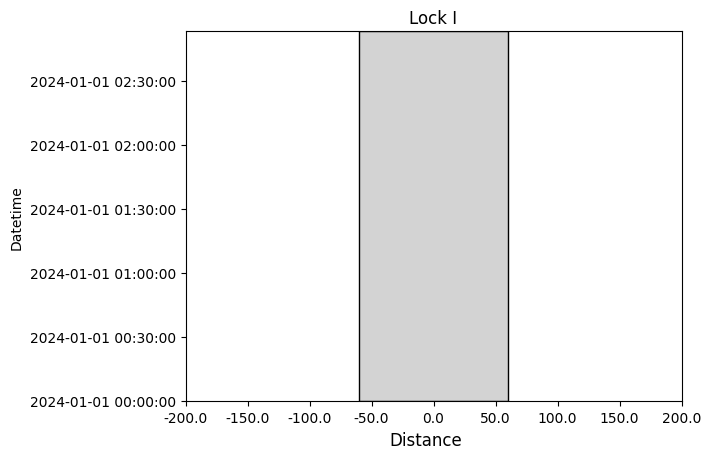

In [32]:
fig, axes = plt.subplots(1,1)
ylim = (min(vessel_1_df['Timestamp'].min(), vessel_2_df['Timestamp'].min(), vessel_3_df['Timestamp'].min()),
        max(vessel_1_df['Timestamp'].max(), vessel_2_df['Timestamp'].max(), vessel_3_df['Timestamp'].max()))

lock_I.create_time_distance_diagram(vessels,ax=axes,ylim=ylim,vessel_colors=['C0','C1'])

axes.set_xlabel('')
axes.set_xlabel('')
axes.set_title('Lock I')

fig.supxlabel('Distance');

In [33]:
lock_df = pd.DataFrame(lock_I.logbook)
lock_df

""


#### Lock II

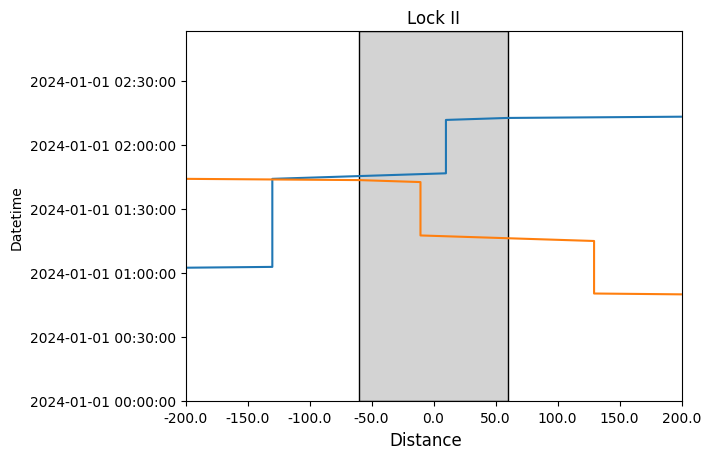

In [34]:
fig, axes = plt.subplots(1,1)
ylim = (min(vessel_1_df['Timestamp'].min(), vessel_2_df['Timestamp'].min()),
        max(vessel_1_df['Timestamp'].max(), vessel_2_df['Timestamp'].max()))

lock_II.create_time_distance_diagram(vessels,ax=axes,ylim=ylim,vessel_colors=['C0','C1'])

axes.set_xlabel('')
axes.set_xlabel('')
axes.set_title('Lock II')

fig.supxlabel('Distance');

In [35]:
lock_df = pd.DataFrame(lock_II.logbook)
lock_df

,Message,Timestamp,Value,Geometry
0,Lock doors closing start,2024-01-01 00:49:56.788965,{},C
1,Lock doors closing stop,2024-01-01 00:49:56.788965,{},C
2,Lock chamber converting start,2024-01-01 00:49:56.788965,{},C
3,Lock chamber converting stop,2024-01-01 01:14:56.788965,{},F
4,Lock doors opening start,2024-01-01 01:14:56.788965,{},F
5,Lock doors opening stop,2024-01-01 01:14:56.788965,{},F
6,Lock doors closing start,2024-01-01 01:17:31.555556,{'visiting_vessels': [<__main__.Vessel object ...,F
7,Lock doors closing stop,2024-01-01 01:17:31.555556,{'visiting_vessels': [<__main__.Vessel object ...,F
8,Lock chamber converting start,2024-01-01 01:17:31.555556,{'visiting_vessels': [<__main__.Vessel object ...,F
9,Lock chamber converting stop,2024-01-01 01:42:31.555556,{'visiting_vessels': [<__main__.Vessel object ...,C


#### Lock III

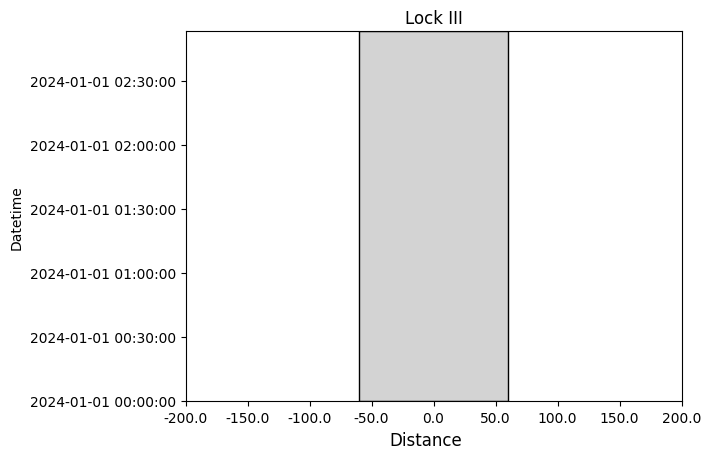

In [36]:
fig, axes = plt.subplots(1,1)
ylim = (min(vessel_1_df['Timestamp'].min(), vessel_2_df['Timestamp'].min()),
        max(vessel_1_df['Timestamp'].max(), vessel_2_df['Timestamp'].max()))

lock_III.create_time_distance_diagram(vessels,ax=axes,ylim=ylim,vessel_colors=['C0','C1'])

axes.set_xlabel('')
axes.set_xlabel('')
axes.set_title('Lock III')

fig.supxlabel('Distance');